In [1]:
# Data preparation
import pandas as pd
import numpy as np
from recreate_icip2022_face_reconstruction.src.det.implementations.DET import DET

# Plotting
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns

# Normalization and cosine distance
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance

# Pyeer
from pyeer.eer_info import get_eer_stats
from pyeer.report import generate_eer_report, export_error_rates
from pyeer.plot import plot_eer_stats

import numpy

# Settings
%matplotlib inline
# figure size in inches optional
rcParams['figure.figsize'] = 8, 8

In [19]:
# Global variables
block_size = 16
feature_extractor = "ArcFace"

# ----
import os
# save_path = f"./DET_curves/{feature_extractor}_{block_size}/"
# filename_plot = f"{}_pemiu{block_size}_performance.svg"
# os.makedirs(save_path, exist_ok=True)

# Evaluation of biometric performance for PEMIU enhanced templates

Ingest dataframes containing path to LFW View 2 Target A and Target B for
- Original image
- PEMIU Shuffled embedding
- PEMIU Reconstructed embedding
- Block Size: See global variable above
- cos_sim between PEMIU Shuffled and Reconstructed embeddings

Add columns pointing to the unmodified embeddings. Reorder the columns for better readability.

In [20]:
df_genuine = pd.read_csv(f"../dataframes/lfw_view2_genuine_pemiu{block_size}.csv", sep=",")
df_impostor = pd.read_csv(f"../dataframes/lfw_view2_impostor_pemiu{block_size}.csv", sep=",")

# Add a column just containing the target name without extension
df_genuine['a_filename'] = df_genuine['a_img'].apply(lambda x: x.split('/')[-1].split('.')[0])
df_genuine['b_filename'] = df_genuine['b_img'].apply(lambda x: x.split('/')[-1].split('.')[0])
df_impostor['a_filename'] = df_impostor['a_img'].apply(lambda x: x.split('/')[-1].split('.')[0])
df_impostor['b_filename'] = df_impostor['b_img'].apply(lambda x: x.split('/')[-1].split('.')[0])

# Add columns with path pointing to unmodified templates
path_unmodified = "../data/features_cleaner/"
df_genuine['a_embedding_unmodified'] = df_genuine['a_filename'].apply(lambda x: f"{path_unmodified}{x}.npy")
df_genuine['b_embedding_unmodified'] = df_genuine['b_filename'].apply(lambda x: f"{path_unmodified}{x}.npy")
df_impostor['a_embedding_unmodified'] = df_impostor['a_filename'].apply(lambda x: f"{path_unmodified}{x}.npy")
df_impostor['b_embedding_unmodified'] = df_impostor['b_filename'].apply(lambda x: f"{path_unmodified}{x}.npy")

# Rename index column
df_genuine = df_genuine.rename(columns = {"Unnamed: 0": "index"})
df_impostor = df_impostor.rename(columns = {"Unnamed: 0": "index"})

# Reorder columns
df_genuine = df_genuine[['index',
                         
                         'a_filename',
                         'a_img',
                         'a_embedding_unmodified',
                         f'a_embedding_pemiu',
                         f'a_embedding_reconstructed',
                         
                         'b_filename',
                         'b_img',
                         'b_embedding_unmodified',
                         f'b_embedding_pemiu',
                         
                         f'cos_sim_a_pemiu_a_pemiu_reconstructed',
                        ]]

# Reorder columns
df_impostor = df_impostor[['index',
                         
                         'a_filename',
                         'a_img',
                         'a_embedding_unmodified',
                         f'a_embedding_pemiu',
                         f'a_embedding_reconstructed',
                         
                         'b_filename',
                         'b_img',
                         'b_embedding_unmodified',
                         f'b_embedding_pemiu',
                         
                         f'cos_sim_a_pemiu_a_pemiu_reconstructed',
                        ]]

## Calculate cos_sim

Calculate cosine similarity of
- target a / b embedding

In [21]:
# Cosine similarity according to Terhörst PEMIU implementation
def cos_sim(a, b):
    a, b = a.reshape(-1), b.reshape(-1)
    return np.dot(a,b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [22]:
# Load embeddings
genuine_a = df_genuine['a_embedding_unmodified'].apply(lambda x: np.load(x)).tolist()
genuine_b = df_genuine['b_embedding_unmodified'].apply(lambda x: np.load(x)).tolist()
impostor_a = df_impostor['a_embedding_unmodified'].apply(lambda x: np.load(x)).tolist()
impostor_b = df_impostor['b_embedding_unmodified'].apply(lambda x: np.load(x)).tolist()

# Calculate cosine similarity using scipy spacial distance
df_genuine['cos_sim_a_b'] = [(cos_sim(x, y)) for x, y in zip(genuine_a, genuine_b)]
df_impostor['cos_sim_a_b'] = [(cos_sim(x, y)) for x, y in zip(impostor_a, impostor_b)]

In [23]:
df_genuine_16 = df_genuine
df_impostor_16 = df_impostor

In [24]:
df_impostor_32.columns

Index(['index', 'a_filename', 'a_img', 'a_embedding_unmodified',
       'a_embedding_pemiu32', 'a_embedding_reconstructed32', 'b_filename',
       'b_img', 'b_embedding_unmodified', 'b_embedding_pemiu32',
       'cos_sim_a_pemiu_a_pemiu_reconstructed32', 'cos_sim_a_b'],
      dtype='object')

## DET

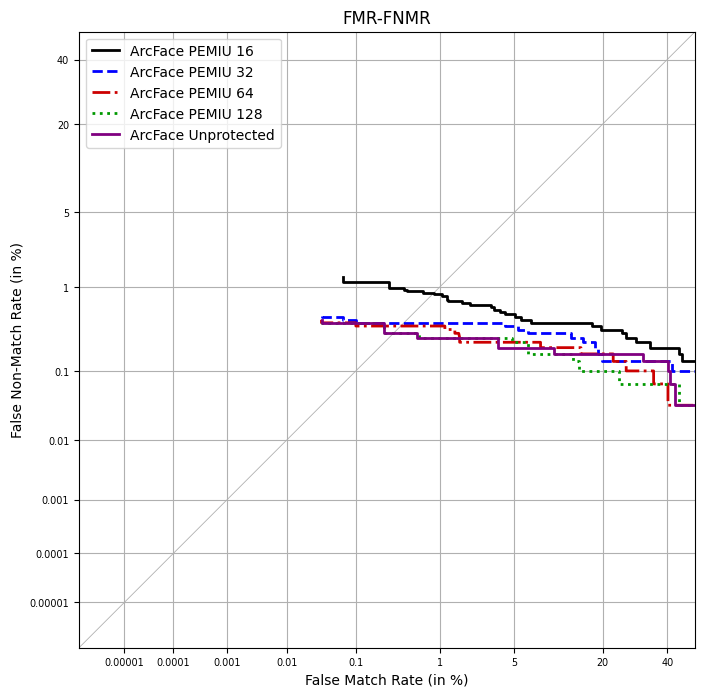

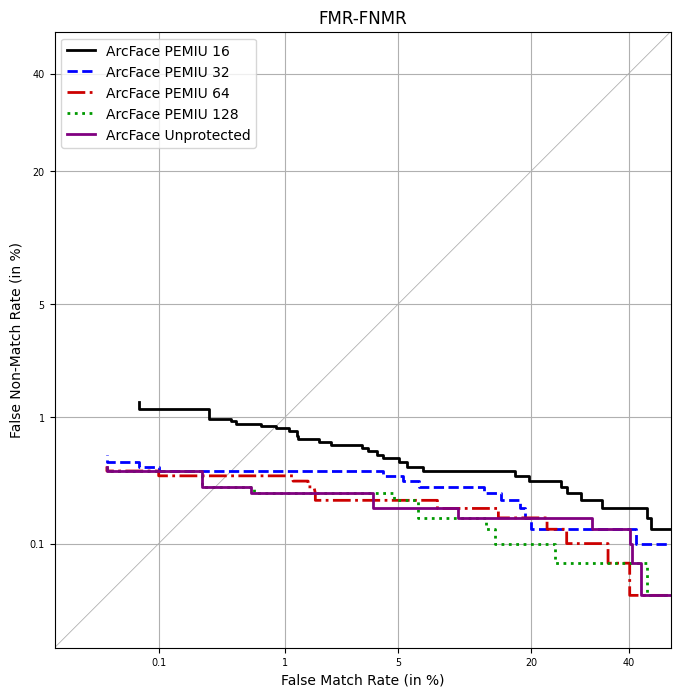

In [26]:
#     df_genuine['cos_sim_a_pemiu_a_pemiu_reconstructed_normalized'],
#    df_impostor['cos_sim_a_pemiu_a_pemiu_reconstructed_normalized'],
save_path = "../recreate_icip2022_face_reconstruction/experiments/experiment_10_elastic/det_curves/"
os.makedirs(save_path, exist_ok=True)

tar0 = df_genuine_16['cos_sim_a_pemiu_a_pemiu_reconstructed']
non0 = df_impostor_16['cos_sim_a_pemiu_a_pemiu_reconstructed']
tar1 = df_genuine_32[f'cos_sim_a_pemiu_a_pemiu_reconstructed32']
non1 = df_impostor_32[f'cos_sim_a_pemiu_a_pemiu_reconstructed32']
tar2 = df_genuine_64[f'cos_sim_a_pemiu_a_pemiu_reconstructed64']
non2 = df_impostor_64[f'cos_sim_a_pemiu_a_pemiu_reconstructed64']
tar3 = df_genuine_128[f'cos_sim_a_pemiu_a_pemiu_reconstructed128']
non3 = df_impostor_128[f'cos_sim_a_pemiu_a_pemiu_reconstructed128']
tar4 = df_genuine_128[f'cos_sim_a_b']
non4 = df_impostor_128[f'cos_sim_a_b']

det = DET(biometric_evaluation_type='algorithm', plot_title='FMR-FNMR', plot_eer_line=True)
det.create_figure()
det.plot(tar=tar0, non=non0, label='ArcFace PEMIU 16')
det.plot(tar=tar1, non=non1, label='ArcFace PEMIU 32')
det.plot(tar=tar2, non=non2, label='ArcFace PEMIU 64')
det.plot(tar=tar3, non=non3, label='ArcFace PEMIU 128')
det.plot(tar=tar4, non=non4, label='ArcFace Unprotected')
det.legend_on()
det.save(f'{save_path}example_algorithm', 'pdf')

det = DET(biometric_evaluation_type='algorithm', plot_title='FMR-FNMR', plot_eer_line=True)

det.x_limits = numpy.array([1e-4, .5])
det.y_limits = numpy.array([1e-4, .5])
det.x_ticks = numpy.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.x_ticklabels = numpy.array(['0.1', '1', '5', '20', '40'])
det.y_ticks = numpy.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.y_ticklabels = numpy.array(['0.1', '1', '5', '20', '40'])

det.create_figure()
det.plot(tar=tar0, non=non0, label='ArcFace PEMIU 16')
det.plot(tar=tar1, non=non1, label='ArcFace PEMIU 32')
det.plot(tar=tar2, non=non2, label='ArcFace PEMIU 64')
det.plot(tar=tar3, non=non3, label='ArcFace PEMIU 128')
det.plot(tar=tar4, non=non4, label='ArcFace Unprotected')
det.legend_on()
det.save(f'{save_path}example_algorithm_axes_final', 'pdf')